In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Data Sourcing

In [3]:
from weather import Weather
weather = Weather().get_data()
weather = Weather().clean_data(weather)

from expeds import Expeds
exped = Expeds().get_data()
exped = Expeds().clean_data(exped)

root_dir = os.path.abspath('')
xls_path = os.path.join(root_dir, 'data\\exped_time_2.xls')
time = pd.read_excel(xls_path)

# Column Dropping

In [29]:
exp_to_drop = ['year','season','route1','route2','nation','leaders','sponsor','success1','success2',
               'ascent1','claimed','disputed','countries','summit_time','term_date','term_reason', 'summit_days',
               'term_note','high_point','traverse','ski','parapente','o2_climb','o2_descent','o2_sleep','o2_medical',
               'o2_taken','o2_unkwn','o2_used','o2_none','other_smts','campsites','accidents','achievment','agency',
               'peak_name','primmem','summiter_deaths','summit_hired','hired_deaths']

exped.drop(columns= exp_to_drop, inplace=True)

exped['summit_date'] = pd.to_datetime(exped.summit_date, errors = 'coerce')
exped['bc_date'] = pd.to_datetime(exped.bc_date , errors = 'coerce')

# Merging

In [112]:
df = time[time['peakid']=='EVER']
df.drop(['peakid'], axis=1, inplace=True)
df['smtdate'] = pd.to_datetime(df.smtdate, errors = 'coerce')

c:\users\kyril\.venvs\himalaya\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
c:\users\kyril\.venvs\himalaya\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Group by date

In [113]:
df_ts = df.dropna()
df_ts.set_index('smtdate', inplace=True)
df_ts = df_ts.groupby(['smtdate']).sum(['smtmembers'])
df_ts = df_ts.asfreq('d')
df_ts = df_ts.fillna(0)
df_ts = df_ts[df_ts.index >= '1960']
df_ts.head()

,year,season,host,success1,smtdays,totdays,termreason,camps,rope,totmembers,smtmembers,mdeaths,tothired,smthired,hdeaths,heightm
smtdate,,,,,,,,,,,,,,,,
1960-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1960-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1960-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1960-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1960-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# ARIMA

## Model

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

p,d,q = 3,0,3

arima = ARIMA(df_ts, order=(p,d,q))
arima = arima.fit()
arima.summary()

## Evaluation

In [ ]:
# Actual vs Fitted
arima.plot_predict(dynamic= False);

### Out-of-sample forecasts (real "future")

In [ ]:
train = df_ts[:'2017']
test = df_ts['2018':]

arima = ARIMA(train, order=(p,d,q))
arima = arima.fit()
arima.summary()

In [ ]:
ypred = arima.forecast(len(test))[0]

In [ ]:
preds = pd.DataFrame(index=test.index, data=ypred)
ts.plot()
plt.plot(preds, color = 'r', label= 'forecast')
plt.legend()
plt.show()

## Auto ARIMA

In [193]:
import pmdarima as pm

arima = pm.auto_arima(train, 
                      start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(arima.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=471.337, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=470.365, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=470.133, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=468.954, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=470.289, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=466.842, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=462.762, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=462.012, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=466.297, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=459.189, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=458.721, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=460.587, Time=0.04 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=460.824, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=458.227, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=461.8

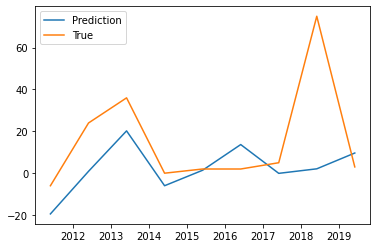

In [194]:
ypred = arima.predict(len(test))

plt.plot(pd.DataFrame(data = ypred, index = test.index, columns=['ypred']), label = 'Prediction')
plt.plot(test, label= 'True')
plt.legend()
plt.show()

# SARIMA

In [114]:
df_ts = df_ts.drop(columns=[
                 'year', 
                 'season', 
                 'host', 
                 'success1',  
                 'termreason',
                'mdeaths',
                 'heightm',
                'smthired', 
                 'hdeaths',
                'totdays'])

df_ts['month'] = df_ts.index.month
df_ts['year'] = df_ts.index.year
df_ts_may = df_ts[df_ts['month']==5]
df_ts_may = df_ts_may.groupby(['year']).agg({'smtdays' : 'mean',
                                'camps' : 'mean',
                                'rope' : 'mean',
                                'totmembers' : 'sum',
                                'smtmembers' : 'sum',
                                'tothired' : 'mean'})

df_ts_may.head()

,smtdays,camps,rope,totmembers,smtmembers,tothired
year,,,,,,
1960,3.774194,0.483871,0.0,51.0,3.0,3.516129
1961,0.000000,0.000000,0.0,0.0,0.0,0.000000
1962,2.000000,0.225806,0.0,14.0,0.0,1.419355
1963,1.322581,0.193548,0.0,20.0,5.0,1.290323
1964,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [126]:
date_rng = pd.date_range(start='1960', end='2020', freq='A-MAY')
df = pd.DataFrame(date_rng, columns=['date'])
df = df.set_index(df.date.dt.year)
df = df.merge(df_ts_may, how='left', left_index=True, right_index=True)
df = df.set_index('date')
df = df.asfreq('A-MAY')

ts = df.smtmembers

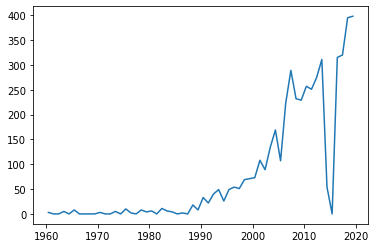

In [216]:
plt.plot(df.smtmembers)

## TS Analysis

p_val:  0.004014189836831847


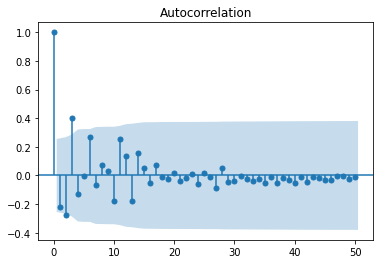

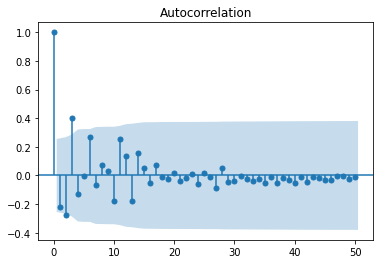

In [175]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

res = adfuller(ts_tr)
print('p_val: ', res[1])

plot_acf(ts_tr, lags=50);

plot_acf(ts_tr, lags=50);

## TS transformation

In [174]:
ts_tr = df_tr.smtmembers_shift

<AxesSubplot:xlabel='date'>

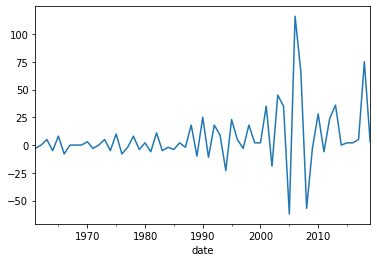

In [173]:
df_tr = df.copy()
df_tr.loc['2014', 'smtmembers'] = int(df_tr.loc['2013', 'smtmembers'])
df_tr.loc['2015', 'smtmembers'] = (int(df_tr.loc['2014', 'smtmembers']) + int(df_tr.loc['2016', 'smtmembers']))/2
df_tr['smtmembers_shift'] = df_tr['smtmembers'] - df_tr['smtmembers'].shift(1)
df_tr = df_tr.dropna()
df_tr['smtmembers_shift'].plot()

<AxesSubplot:xlabel='date'>

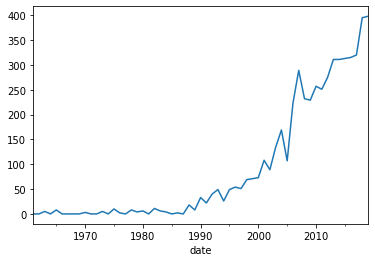

In [218]:
df_tr['smtmembers'].plot()

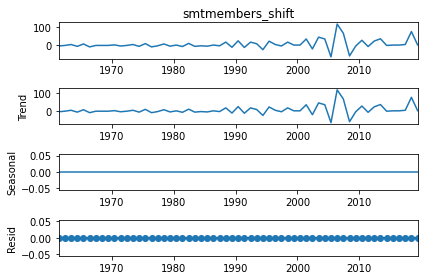

In [176]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(ts_tr, model='additive')
result_add.plot();

In [212]:
import pmdarima as pm

train = ts_tr[:'2010']
test = ts_tr['2011':]

sarima = pm.auto_arima(train, 
                      start_p=0, 
                      start_q=0,
                      test='adf',
                      max_p=3, 
                      max_q=3,
                      m=12,
                      d=None,
                      seasonal=True,
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=376.462, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=377.718, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=373.976, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=368.695, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=376.586, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=369.329, Time=0.05 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=370.694, Time=0.38 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=370.694, Time=0.52 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=369.233, Time=0.15 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=370.681, Time=0.24 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=370.615, Time=0.40 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=373.931, Time=0.17 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,0,1)(0,1,1)[12]             : AI

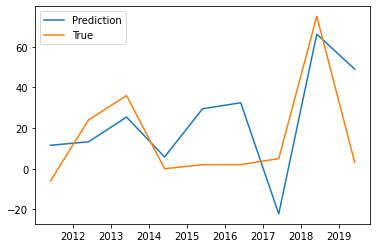

In [213]:
ypred = sarima.predict(len(test))

plt.plot(pd.DataFrame(data = ypred, index = test.index, columns=['ypred']), label = 'Prediction')
plt.plot(test, label= 'True')
plt.legend()
plt.show()

(array(10957.), array(18262.))

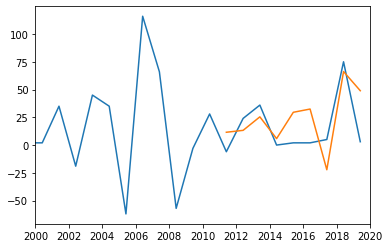

In [214]:
plt.plot(df_tr.smtmembers_shift)
plt.plot(pd.DataFrame(data = ypred, index = test.index, columns=['ypred']), label = 'Prediction')
plt.xlim('2000', "2020")

In [ ]:
# ARIMA(0,0,1)(0,1,1)[12]

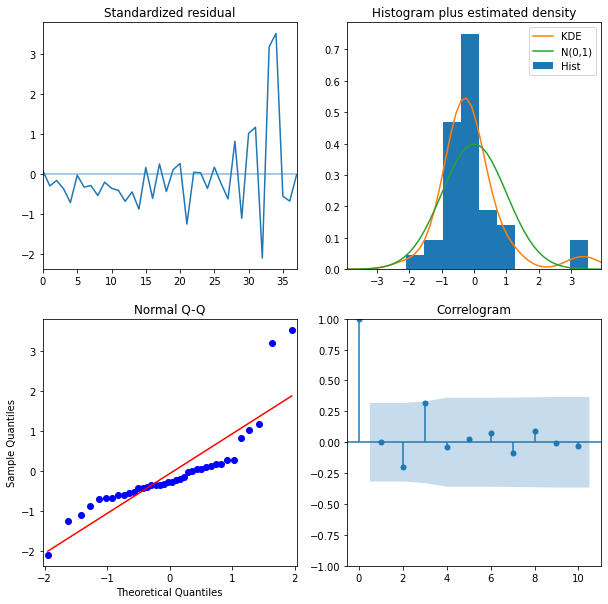

In [195]:
sarima.plot_diagnostics(figsize=(10,10));

In [203]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred[:,None], y_true[:,None]]), axis=1)
    maxs = np.amax(np.hstack([y_pred[:,None], y_true[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true)[1]                      # Lag 1 Autocorrelation of Error
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [215]:
forecast_accuracy(ypred, test)

c:\users\kyril\.venvs\himalaya\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
c:\users\kyril\.venvs\himalaya\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':
c:\users\kyril\.venvs\himalaya\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


{'mape': inf,
 'me': 7.764559227640992,
 'mae': 20.507449245082178,
 'mpe': inf,
 'rmse': 23.992625745729296,
 'acf1': -0.05220874310406166,
 'corr': 0.5628284121085361,
 'minmax': 1.2924373116090364}

# RNN

In [20]:
df_ts.head()

,year,season,host,success1,smtdays,totdays,termreason,camps,rope,totmembers,smtmembers,mdeaths,tothired,smthired,hdeaths,heightm
smtdate,,,,,,,,,,,,,,,,
1960-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1960-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1960-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1960-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1960-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
df_ts = df_ts.drop(columns=[
                 'year', 
                 'season', 
                 'host', 
                 'success1',  
                 'termreason',
                'mdeaths',
                 'heightm',
                'smthired', 
                 'hdeaths',
                'totdays'])

df_ts['month'] = df_ts.index.month
df_ts['year'] = df_ts.index.year
df_ts_may = df_ts[df_ts['month']==5]
df_ts_may = df_ts_may.groupby(['year']).agg({'smtdays' : 'mean',
                                'camps' : 'mean',
                                'rope' : 'mean',
                                'totmembers' : 'sum',
                                'smtmembers' : 'sum',
                                'tothired' : 'mean'})

df_ts_may.head()

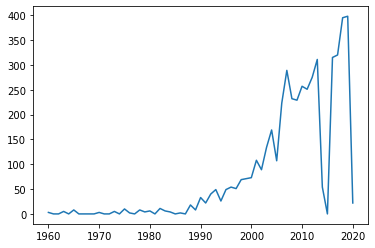

In [40]:
plt.plot(df_ts_may.smtmembers)

# Exploration

In [134]:
df_ts['month'] = df_ts.index.month
df_ts['year'] = df_ts.index.year

In [142]:
df_month = df_ts.groupby(pd.Grouper(freq="M")).agg({'smtmembers': 'sum',
                                                   'month' : 'mean'})

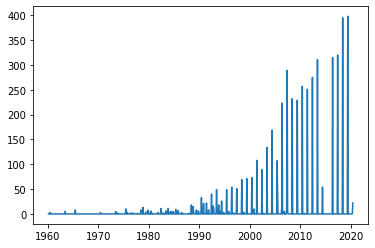

In [143]:
plt.plot(df_month.smtmembers)

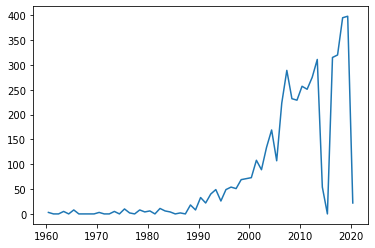

In [144]:
df_may = df_month[df_month['month']==5]
plt.plot(df_may.smtmembers)

In [150]:
train = df_may.loc[:'2016', 'smtmembers']
test = df_may.loc['2017':, 'smtmembers']

model = pm.auto_arima(train, 
                      start_p=0, 
                      start_q=0,
                      test='adf',
                      max_p=3, 
                      max_q=3,
                      m=1,
                      d=0,
                      seasonal=True,
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=684.726, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=632.317, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=636.461, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=704.454, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=634.013, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=627.856, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=622.581, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=602.692, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=605.813, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=603.317, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=612.644, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=601.868, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=623.719, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=604.809, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=602.3

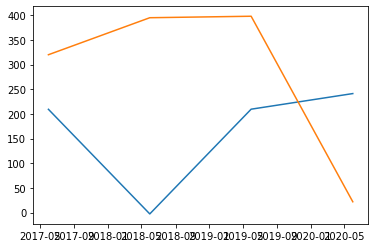

In [151]:
ypred = model.predict(len(test))

plt.plot(pd.DataFrame(data = ypred, index = test.index, columns=['ypred']))
plt.plot(test)
plt.show()

# Weather Evoluation

In [6]:
weather.set_index('date_time', inplace=True)

In [9]:
weather['month'] = weather.index.month
weather['year'] = weather.index.year

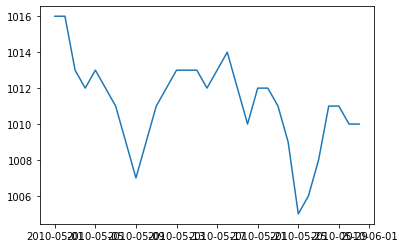

In [15]:
plt.plot(weather['2010-05'].pressure)

In [57]:
weather['rolling_pressure_past'] = weather['pressure'].rolling(window=3).mean()
weather['rolling_pressure_futur'] = weather['pressure'].shift(-2).rolling(window=3).mean()
weather['stability'] = weather['rolling_pressure_futur'] - weather['rolling_pressure_past']

# Snow Accumulation

In [227]:
exped = Expeds().get_data()
exped = Expeds().clean_data(exped)

exp_to_drop = ['year','season','route1','route2','nation','leaders','sponsor','success1','success2',
               'ascent1','claimed','disputed','countries','summit_time','term_date',
               'term_note','high_point','traverse','ski','parapente','o2_climb','o2_descent','o2_sleep','o2_medical',
               'o2_taken','o2_unkwn','o2_used','o2_none','other_smts','campsites','accidents','achievment','agency',
               'peak_name','primmem','summiter_deaths','summit_members','summit_hired','hired_deaths']

exped.drop(columns= exp_to_drop, inplace=True)

exped['summit_date'] = pd.to_datetime(exped.summit_date, errors = 'coerce')
exped['bc_date'] = pd.to_datetime(exped.bc_date , errors = 'coerce')

from weather import Weather
weather = Weather().get_data()
weather = Weather().clean_data(weather)

exped = exped.set_index('summit_date')
wet = weather.set_index('date_time')
df = exped.merge(wet, how='left', left_index=True, right_index=True)

df = df.reset_index()
df.drop(columns=['moonrise', 'moonset', 'sunrise', 'sunset'], inplace = True)
df = df.rename(columns={'index' : 'summit_date'})

df = df[df['term_reason']!= 'no_attempt_climb']
df = df[df['term_reason']!= 'no_reach_camp']

df.head()

,summit_date,exp_id,peak_id,host,bc_date,summit_days,tot_days,term_reason,camps,rope,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
5,NaT,SHNW10101,SHNW,Nepal,2010-04-04,0,54,Success_main,3,3000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaT,EVER10303,EVER,China,2010-08-16,0,77,Bad_conditions,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaT,CHOY10342,CHOY,China,NaT,0,0,Unknown,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaT,CHOY10118,CHOY,China,NaT,0,0,Illness,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaT,PYRM10301,PYRM,Nepal,NaT,0,0,lack_of_motivation,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [231]:
df = df.dropna()

In [234]:
df.head()

,summit_date,exp_id,peak_id,host,bc_date,summit_days,tot_days,term_reason,camps,rope,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
331,2010-03-12,TKRG10101,TKRG,Nepal,2010-03-06,6,8,Success_main,0,0,...,-15.0,24.0,10.0,67.0,0.0,1020.0,-1.0,10.0,270.0,15.0
332,2010-03-18,BHRS10101,BHRS,Nepal,2010-03-16,2,3,Success_main,1,0,...,-11.0,13.0,43.0,90.0,3.4,1025.0,-3.0,8.0,252.0,7.0
333,2010-03-31,KYR110101,KYR1,Nepal,2010-03-25,6,13,Bad_weather,2,750,...,-12.0,25.0,51.0,86.0,0.0,1010.0,-2.0,9.0,240.0,19.0
334,2010-04-01,PUMO10103,PUMO,Nepal,2010-03-20,12,43,Lack_sse,2,400,...,-13.0,24.0,20.0,80.0,0.0,1011.0,-1.0,10.0,254.0,16.0
335,2010-04-01,URMA10101,URMA,Nepal,2010-03-29,3,3,Success_main,0,0,...,-13.0,24.0,20.0,80.0,0.0,1011.0,-1.0,10.0,254.0,16.0


In [256]:
df['cumul_snow'] = 0

for index, row in df.iterrows():
    date1 = row['bc_date'].date()
    date2 = row['summit_date'].date()
    acc_snow = wet.loc[date1:date2, 'totalSnow_cm'].sum()
    df.loc[index, 'cumul_snow'] = acc_snow
    

In [257]:
df

,summit_date,exp_id,peak_id,host,bc_date,summit_days,tot_days,term_reason,camps,rope,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,cumul_snow
331,2010-03-12,TKRG10101,TKRG,Nepal,2010-03-06,6,8,Success_main,0,0,...,24.0,10.0,67.0,0.0,1020.0,-1.0,10.0,270.0,15.0,0.0
332,2010-03-18,BHRS10101,BHRS,Nepal,2010-03-16,2,3,Success_main,1,0,...,13.0,43.0,90.0,3.4,1025.0,-3.0,8.0,252.0,7.0,11.6
333,2010-03-31,KYR110101,KYR1,Nepal,2010-03-25,6,13,Bad_weather,2,750,...,25.0,51.0,86.0,0.0,1010.0,-2.0,9.0,240.0,19.0,10.5
334,2010-04-01,PUMO10103,PUMO,Nepal,2010-03-20,12,43,Lack_sse,2,400,...,24.0,20.0,80.0,0.0,1011.0,-1.0,10.0,254.0,16.0,10.7
335,2010-04-01,URMA10101,URMA,Nepal,2010-03-29,3,3,Success_main,0,0,...,24.0,20.0,80.0,0.0,1011.0,-1.0,10.0,254.0,16.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695,2019-12-08,AMAD19357,AMAD,Nepal,2019-11-23,15,17,Success_main,2,0,...,23.0,0.0,21.0,0.0,1019.0,-14.0,10.0,334.0,11.0,0.0
3697,2020-02-02,AMAD19402,AMAD,Nepal,2020-01-27,6,9,Success_main,3,0,...,17.0,12.0,27.0,0.1,1019.0,-19.0,10.0,337.0,9.0,0.1
3698,2020-02-24,EVER19401,EVER,Nepal,2019-12-19,67,73,lack_of_motivation,3,150,...,11.0,32.0,76.0,4.3,1018.0,-16.0,8.0,213.0,6.0,42.6
3700,2020-02-27,EVER19403,EVER,Nepal,2020-02-24,3,6,Bad_conditions,1,0,...,27.0,6.0,57.0,0.0,1018.0,-16.0,10.0,352.0,15.0,5.9
